# CSE 252B: Computer Vision II, Winter 2022 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 2, 2022, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. If you are uncertain about using a specific package, then please ask the instructional staff whether or not it is allowable.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

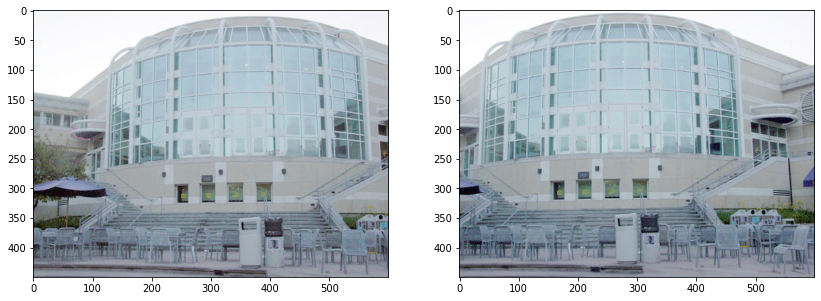

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# open the input images
I1 = np.array(Image.open('price_center20.jpg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpg'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

## Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.jpeg
contains image 1 and the file price_center21.jpeg contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features

A typical implementation takes around <strong>30</strong> seconds to run. If yours takes more than <strong>60</strong> seconds, you may lose points.

In [2]:
def ImageGradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
    
    """your code here"""
    k = 1/12 * np.array([-1, 8, 0, -8, 1]) # Convolution kernel
    Ix = np.zeros((m,n,3))
    Iy = np.zeros((m,n,3))
    for channel in range(I.shape[2]):
        for row in range(m):
            convolve_output = np.convolve(I[row, :, channel], k.T, 'valid')
            convolve_output_padded = np.pad(convolve_output, (2,2), 'constant')
            Ix[row, :, channel] = convolve_output_padded
        for col in range(n):
            convolve_output = np.convolve(I[:, col, channel], k, 'valid')
            convolve_output_padded = np.pad(convolve_output, (2,2), 'constant')
            Iy[:,col, channel] = convolve_output_padded
    return Ix, Iy
  

def MinorEigenvalueImage(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0.
    """your code here"""
    Ixx1 = np.multiply(Ix[:,:,0], Ix[:,:,0])
    Ixx2 = np.multiply(Ix[:,:,1], Ix[:,:,1])
    Ixx3 = np.multiply(Ix[:,:,2], Ix[:,:,2])
    Ixx  = Ixx1 + Ixx2 + Ixx3
    
    Iyy1 = np.multiply(Iy[:,:,0], Iy[:,:,0])
    Iyy2 = np.multiply(Iy[:,:,1], Iy[:,:,1])
    Iyy3 = np.multiply(Iy[:,:,2], Iy[:,:,2])
    Iyy  = Iyy1 + Iyy2 + Iyy3
    
    Ixy1 = np.multiply(Ix[:,:,0], Iy[:,:,0])
    Ixy2 = np.multiply(Ix[:,:,1], Iy[:,:,1])
    Ixy3 = np.multiply(Ix[:,:,2], Iy[:,:,2])
    Ixy  = Ixy1 + Ixy2 + Ixy3
    
    half = int(np.floor(w/2))
    for i in range(half, m-half):
        for j in range(half, n-half):
            gradMatrix = np.array([[np.sum(Ixx[i-half:i+half+1, j-half:j+half+1]),
                                   np.sum(Ixy[i-half:i+half+1, j-half:j+half+1])],
                                   [np.sum(Ixy[i-half:i+half+1, j-half:j+half+1]),
                                   np.sum(Iyy[i-half:i+half+1, j-half:j+half+1])]])
            trace = np.trace(gradMatrix)
            determinant = 4*np.linalg.det(gradMatrix)
            rootTerm = max(0, trace*trace - determinant)
            J0[i,j] = (0.5) * (trace - np.sqrt(rootTerm))
    return J0
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    import scipy.ndimage as ndi
    J2 = J.copy()
    """your code here"""
    w = ndi.maximum_filter(J2, size=w_nms, mode='constant', cval=0.0)
    J2[ J2 != w] = 0
    return J2
  
  
def ForstnerCornerDetector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    """your code here"""
    J0 = MinorEigenvalueImage(Ix, Iy, w)
    J1 = np.copy(J0)
    J1[J1 < t] = 0
                
    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = NMS(J1, w_nms)
    
    #Detect corners.
    """your code here"""
    half = int(np.floor(w/2))
    mask = J2!=0
    C = np.sum(mask)
    pts = np.array((2, C))
    
    Ixx1 = np.multiply(Ix[:,:,0], Ix[:,:,0])
    Ixx2 = np.multiply(Ix[:,:,1], Ix[:,:,1])
    Ixx3 = np.multiply(Ix[:,:,2], Ix[:,:,2])
    Ixx  = Ixx1 + Ixx2 + Ixx3
    
    Iyy1 = np.multiply(Iy[:,:,0], Iy[:,:,0])
    Iyy2 = np.multiply(Iy[:,:,1], Iy[:,:,1])
    Iyy3 = np.multiply(Iy[:,:,2], Iy[:,:,2])
    Iyy  = Iyy1 + Iyy2 + Iyy3
    
    Ixy1 = np.multiply(Ix[:,:,0], Iy[:,:,0])
    Ixy2 = np.multiply(Ix[:,:,1], Iy[:,:,1])
    Ixy3 = np.multiply(Ix[:,:,2], Iy[:,:,2])
    Ixy  = Ixy1 + Ixy2 + Ixy3
    
    xIxx = np.zeros((m,n))
    xIxy = np.zeros((m,n))
    yIyy = np.zeros((m,n))
    yIxy = np.zeros((m,n))
    for i in range(m):
        xIxx[i, :] = i * Ixx[i, :]
        xIxy[i, :] = i * Ixy[i, :]
    for j in range(n):
        yIyy[:, j] = j * Iyy[:, j]
        yIxy[:, j] = j * Ixy[:, j]
    
    pts_x = []
    pts_y = []
    half = int(np.floor(w/2))
    for i in range(half, m-half):
        for j in range(half, n-half):
            if(J2[i,j] != 0):
                A = np.array([[np.sum(Ixx[i-half:i+half+1, j-half:j+half+1]),
                               np.sum(Ixy[i-half:i+half+1, j-half:j+half+1])],
                              [np.sum(Ixy[i-half:i+half+1, j-half:j+half+1]),
                               np.sum(Iyy[i-half:i+half+1, j-half:j+half+1])]])
                b = np.array([[np.sum(np.add(xIxx[i-half:i+half+1, j-half:j+half+1], yIxy[i-half:i+half+1, j-half:j+half+1]))],
                              [np.sum(np.add(xIxy[i-half:i+half+1, j-half:j+half+1], yIyy[i-half:i+half+1, j-half:j+half+1]))]])
                x = np.dot(np.linalg.pinv(A),b)
                pts_x.append(x[1])
                pts_y.append(x[0])

    pts = np.array([pts_x, pts_y]).reshape((2, C))
    return C, pts, J0, J1, J2


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    Ix, Iy = ImageGradient(I)
    C, pts, J0, J1, J2 = ForstnerCornerDetector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

took 20.234938 secs


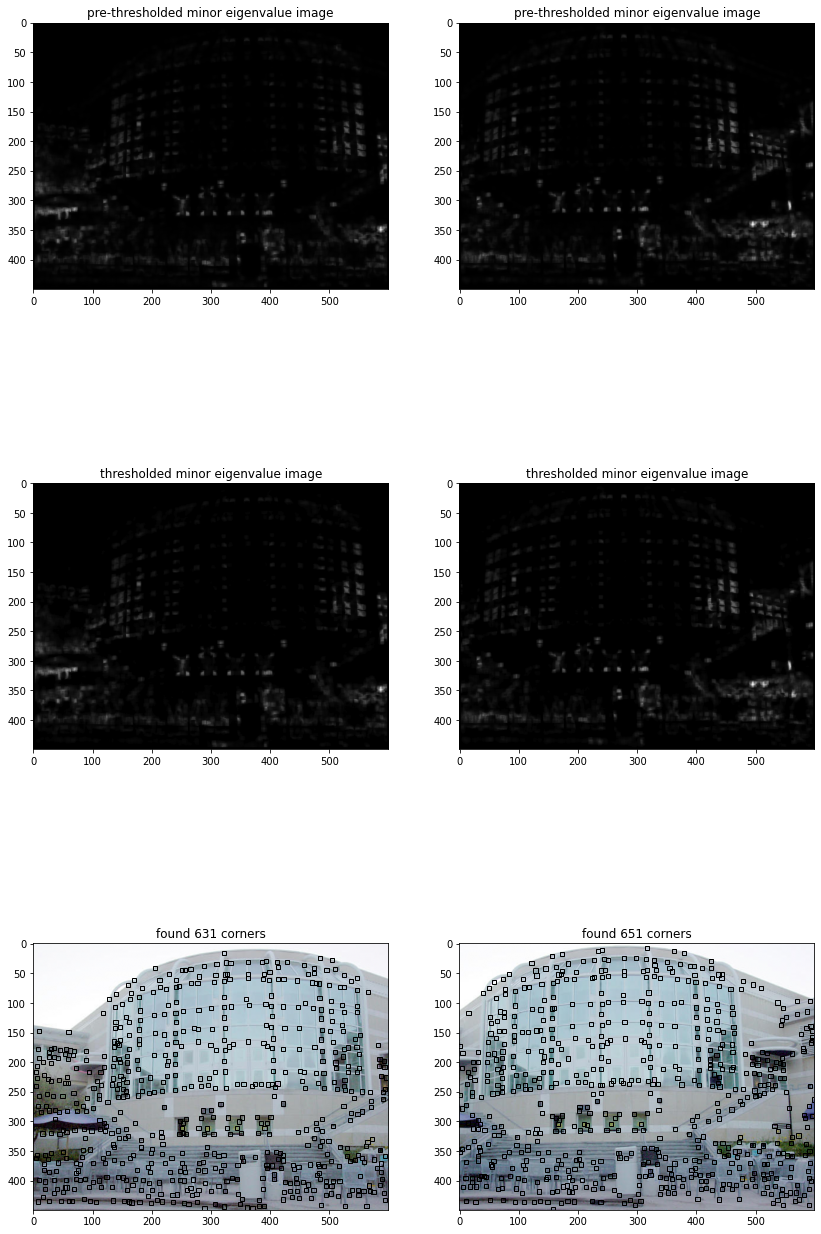

In [3]:
# input images
I1 = np.array(Image.open('price_center20.jpg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpg'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.05
w_nms = 9

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.05
* w_nms = 9
* C1 = 631
* C2 = 651

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that 160-240 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

**Note: You must center each window at the sub-pixel corner
coordinates while computing normalized cross correlation; otherwise, you
will lose points.**

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

A typical implementation takes around <strong>10</strong> seconds to run. If yours takes more than <strong>30</strong> seconds, you may lose points.

In [4]:
def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # Do ensure that windows are centered at the sub-pixel co-ordinates 
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    def bilinear_interpolation(I, x, y, half):
        x_s0 = int(x)
        x_s1 = x_s0 + 1
        y_s0 = int(y)
        y_s1 = y_s0 + 1
        I0 = I[x_s0 - half: x_s0 + half + 1, y_s0 - half: y_s0 + half + 1] * (x_s1 - x) + \
             I[x_s1 - half: x_s1 + half + 1, y_s0 - half: y_s0 + half + 1] * (x - x_s0)
        I1 = I[x_s0 - half: x_s0 + half + 1, y_s1 - half: y_s1 + half + 1] * (x_s1 - x) + \
             I[x_s1 - half: x_s1 + half + 1, y_s1 - half: y_s1 + half + 1] * (x - x_s0)
        return I0 * (y_s1 - y) + I1 * (y - y_s0)
        
    def correlation(window1, window2):
        window1_std = window1 - np.mean(window1)
        window2_std = window2 - np.mean(window2)
        window1_prod = window1_std * window1_std
        window2_prod = window2_std * window2_std
        corrVal = np.sum(window1_std * window2_std) / np.sqrt(np.sum(window1_prod) * np.sum(window2_prod))
        assert(-1.0 <= corrVal <= 1.0)
        return corrVal
    
    m, n = I1.shape[:2]
    half = int(np.floor(w/2))
    I1c = np.zeros((m+half+half, n+half+half, 3))
    I2c = np.zeros((m+half+half, n+half+half, 3))
    I1c[:,:,0] = np.pad(I1[:,:,0], [(half, half), (half, half)], 'constant')
    I1c[:,:,1] = np.pad(I1[:,:,1], [(half, half), (half, half)], 'constant')
    I1c[:,:,2] = np.pad(I1[:,:,2], [(half, half), (half, half)], 'constant')
    
    I2c[:,:,0] = np.pad(I2[:,:,0], [(half, half), (half, half)], 'constant')
    I2c[:,:,1] = np.pad(I2[:,:,1], [(half, half), (half, half)], 'constant')
    I2c[:,:,2] = np.pad(I2[:,:,2], [(half, half), (half, half)], 'constant')
    
    windowI1R = np.zeros((w,w,pts1.shape[1]))
    windowI1G = np.zeros((w,w,pts1.shape[1]))
    windowI1B = np.zeros((w,w,pts1.shape[1]))
    windowI2R = np.zeros((w,w,pts2.shape[1]))
    windowI2G = np.zeros((w,w,pts2.shape[1]))
    windowI2B = np.zeros((w,w,pts2.shape[1]))
    
    for i in range(pts1.shape[1]):
        x, y = pts1[0][i] + half, pts1[1][i] + half
        windowR = bilinear_interpolation(I1c[:,:,0], y, x, half)
        windowG = bilinear_interpolation(I1c[:,:,1], y, x, half)
        windowB = bilinear_interpolation(I1c[:,:,2], y, x, half)
        windowI1R[:,:,i] = windowR
        windowI1G[:,:,i] = windowG
        windowI1B[:,:,i] = windowB
        
    for i in range(pts2.shape[1]):
        x, y = pts2[0][i] + half, pts2[1][i] + half
        windowR = bilinear_interpolation(I2c[:,:,0], y, x, half)
        windowG = bilinear_interpolation(I2c[:,:,1], y, x, half)
        windowB = bilinear_interpolation(I2c[:,:,2], y, x, half)
        windowI2R[:,:,i] = windowR
        windowI2G[:,:,i] = windowG
        windowI2B[:,:,i] = windowB
        
    scores = np.zeros((pts1.shape[1], pts2.shape[1]))
    for i in range(windowI1R.shape[-1]):
        for j in range(windowI2R.shape[-1]):
            if(np.linalg.norm(pts1[:, i] - pts2[:, j]) < p):
                scores[i, j] = min(correlation(windowI1R[:, :, i], windowI2R[:, :, j]),
                                   min(correlation(windowI1G[:, :, i], windowI2G[:, :, j]),
                                       correlation(windowI1B[:, :, i], windowI2B[:, :, j])))
            else:
                scores[i, j] = -1.0
    return scores


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    
    """your code here"""
    inds = []
    pts_x = []
    pts_y = []
    mask = np.ones(scores.shape)
    masked_corr = np.multiply(scores, mask)
    while np.max(masked_corr) > t:
        index = np.unravel_index(np.argmax(masked_corr, axis=None), masked_corr.shape)
        best_val = np.amax(scores)
        scores[index[0], index[1]] = -1
        next_best = max(np.amax(scores[index[0], :]), np.amax(scores[:, index[1]]))
        scores[index[0], index[1]] = best_val
        if((1 - scores[index[0], index[1]]) < ((1 - next_best) * d)):
            pts_x.append(index[0])
            pts_y.append(index[1])
        mask[index[0], :] = 0
        mask[:, index[1]] = 0
        masked_corr = np.multiply(scores, mask)
    inds = np.array([pts_x, pts_y])
    return inds



def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d)
    return inds

took 10.364639 secs


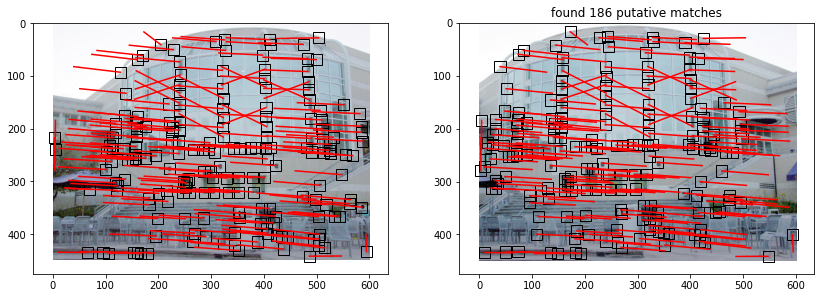

unique points in image 1: 186
unique points in image 2: 186


In [6]:
# parameters to tune
w = 21
t = 0.87
d = 0.80
p = 100

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 15
* t = 0.009
* d = 0.80
* p = 100
* num_matches = 207

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


took 0.057186 secs
6 iterations
inlier count:  160
inliers:  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 182, 184, 185]
MSAC Cost=284.459266215
H_MSAC =
[[ 1.07268852e-02 -1.08659914e-05 -9.81954562e-01]
 [ 3.60241631e-04  1.03366979e-02 -1.88275006e-01]
 [ 1.52030684e-06  1.36421776e-07  9.78348393e-03]]


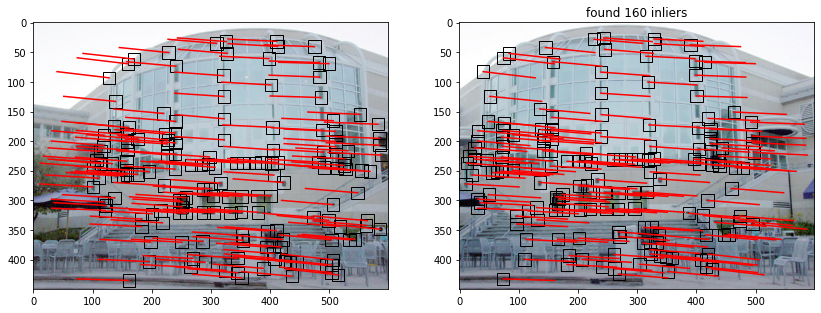

In [9]:
from scipy.stats import chi2
import random

def DisplayResults(H, title):
    print(title+' =')
    print (H/np.linalg.norm(H)*np.sign(H[-1,-1]))

def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def calculateConsensusCost(error, tol, count):
    '''
        Helper function to calculate consensus cost
    '''
    inlier_indices = []
    cost = 0
    for i in range(count):
        if(error[i] <= tol):
            cost += error[i]
            inlier_indices.append(i)
        else:
            cost += tol
    return cost, inlier_indices

def fourPointSolution(pts):
    '''
        pts: 3x4 points
    '''
    pts = Homogenize(pts)
    x = pts[:, :3]
    x4 = pts[:, -1].reshape(3,1)
    
    lam = (np.linalg.inv(x) @ x4).reshape(3,1)
    hInv = np.hstack((lam[0] * x[:, 0].reshape(3,1),
                     lam[1] * x[:, 1].reshape(3,1),
                     lam[2] * x[:, 2].reshape(3,1)))
    return hInv

def getH12(hInv1, hInv2):
    return hInv2 @ np.linalg.inv(hInv1)

def calculateSampsonError(H, pts1, pts2):
    '''
        pts1, pts2 = inhomogenous coords, 2n
        H12 = 3x1
    '''
    error_points = []
    delta_vectors = []
    for i in range(pts1.shape[1]):
        x2 = pts2[0,i]
        y2 = pts2[1,i]
        x1 = pts1[0,i]
        y1 = pts1[1,i]
        J = np.array([[-H[1, 0] + y2*H[2,0], -H[1,1] + y2*H[2,1], 0, x1*H[2,0] + y1*H[2,1] + H[2,2]],
                      [H[0,0] - x2*H[2,0], H[0,1] - x2*H[2,1], -x1*H[2,0] - y1*H[2,1] - H[2,2], 0]])
        epsilon = np.array([-(x1*H[1,0] + y1*H[1,1] + H[1,2]) + y2*(x1*H[2,0] + y1*H[2,1] + H[2,2]),
                            x1*H[0,0] + y1*H[0,1] + H[0,2] - x2*(x1*H[2,0] + y1*H[2,1] + H[2,2])])
        
        lambdas = -np.linalg.inv(J @ J.T) @ epsilon
        errors = epsilon.T @ np.linalg.inv(J @ J.T) @ epsilon
        error_points.append(errors)
        delta = J.T @ lambdas
        delta_vectors.append(delta)
    error_points = np.array(error_points)
    delta_vectors = np.array(delta_vectors)
    return delta_vectors.T, error_points


def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    """your code here"""
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,3))
    inliers = np.random.randint(0, 200, size=100)
    
    while(trials < max_trials and consensus_min_cost > thresh):
        indices = random.sample(range(pts1.shape[1]), 4)
        x1_points = pts1[:, indices]
        x2_points = pts2[:, indices]
        Hinv1 = fourPointSolution(x1_points)
        Hinv2 = fourPointSolution(x2_points)
        H12 = getH12(Hinv1, Hinv2)
        
        _, errors = calculateSampsonError(H12, pts1, pts2)
        consensus_cost, inlier_indices = calculateConsensusCost(errors, tol, pts1.shape[1])
        if(consensus_cost < consensus_min_cost):
            consensus_min_cost = consensus_cost
            consensus_min_cost_model = H12
            inliers = inlier_indices
            w = len(inlier_indices) / pts1.shape[1]
            max_trials = np.log(1 - p) / np.log(1 - (w**4))
        trials += 1
    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 
thresh = 200
codim = 2
p = 0.99
alpha = 0.95
tol = chi2.ppf(alpha, codim) * 1

tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
DisplayResults(H_MSAC, 'H_MSAC')

# display the figures
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d inliers'%xin1.shape[1])
for i in range(xin1.shape[1]):
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 5.99
* threshold = 200
* num_inliers = 104
* num_attempts = 70

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [7]:
def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    
    """your code here"""
    num_axes = pts.shape[0]
    var = np.var(pts, 1).reshape(-1, 1)
    mean = np.mean(pts,1).reshape(-1, 1)
    var_sum = np.sum(var)
    s = np.sqrt(num_axes / var_sum)
        
    T = np.eye(pts.shape[0]+1)
    for i in range(T.shape[0]-1):
        T[i,i] = s
        T[i,-1] = -mean[i] * s

    points_homogenous = Homogenize(pts)
    for i in range(pts.shape[1]):
        points_homogenous[:,i] = np.matmul(T, points_homogenous[:,i])
    return points_homogenous, T

def DLT(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 1
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation   
    #    cost - Sampson cost for the above DLT Estimate H. Assume points in image 1 as scene points.
    
    """your code here"""
    
    # data normalization
    if normalize:
        x1_h, T1 = Normalize(x1)
        x2_h, T2 = Normalize(x2)
    else:
        x1_h = Homogenize(x1)
        x2_h = Homogenize(x2)
    A = []
    for i in range(x1.shape[1]):
        x1i = x1_h[:, i].reshape(-1, 1)
        x2i = x2_h[:, i].reshape(-1, 1)
        u, s, vh = np.linalg.svd(x2i)
        x_LN = u[:, s.shape[0]: x2i.shape[0]].T
        A.append(np.kron(x_LN, x1i.T))
    A = np.concatenate(A)
    _ , _, V = np.linalg.svd(A)
    H = V[-1, :]
    H = np.reshape(H, (3,3))
    # data denormalize
    if normalize:
        H = np.linalg.inv(T2) @ H @ T1
    _, errors = calculateSampsonError(H, x1, x2)
    cost = np.sum(errors)
    return H, cost

# compute the linear estimate without data normalization
print ('Running DLT without data normalization')
time_start=time.time()
H_DLT, cost = DLT(xin1, xin2, normalize=False)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)


# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT, cost = DLT(xin1, xin2, normalize=True)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

Running DLT without data normalization
took 0.015667 secs
Cost=54.044177824
Running DLT with data normalization
took 0.018819 secs
Cost=54.168952894


In [8]:
# display your H_DLT, scaled with its frobenius norm
DisplayResults(H_DLT, 'H_DLT')

H_DLT =
[[ 1.10820744e-02 -4.94024645e-05 -9.86254963e-01]
 [ 3.16981860e-04  1.07529646e-02 -1.64181170e-01]
 [ 1.25806255e-06  6.59199246e-09  1.03513118e-02]]


## Problem 5 (Programming): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors.
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the planar projective transformation matrix $\boldsymbol{H}_\text{LM}$, scaled
  such that $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [9]:
def Sinc(x):
    """your code here"""
    if(x == 0):
        return 1
    return np.sin(x) / x

def dSinc(x):
    if(x == 0):
        return 0
    else:
        val = (np.cos(x) / x) - (np.sin(x) / np.power(x, 2))
        return val

def Parameterize(P):
    # wrapper function to interface with LM
    # takes all optimization variables and parameterizes all of them
    # in this case it is just P, but in future assignments it will
    # be more useful
    return ParameterizeHomog(P.reshape(-1,1))


def Deparameterize(p):
    # Deparameterize all optimization variables
    return DeParameterizeHomog(p)


def ParameterizeHomog(V):
    # Given a homogeneous vector V return its minimal parameterization
    """your code here"""
    V = V / np.linalg.norm(V) * np.sign(V[-1])
    v_hat = 2*V[1:]/Sinc(np.arccos(V[0]))
    if(np.linalg.norm(v_hat) > np.pi):
        v_hat = (1 - 2*np.pi/np.linalg.norm(v_hat) * np.ceil((np.linalg.norm(v_hat)-np.pi)/(2*np.pi)))*v_hat
    return v_hat    


def DeParameterizeHomog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    """your code here"""
    norm = np.linalg.norm(v)
    a = np.array([[np.cos(norm / 2.0)]])
    b = Sinc(norm / 2.0) / 2.0 * v
    v_bar = np.vstack((a, b))
    return v_bar


def Dp_dp(p):
    '''
        Helper function to return calculation of derivative for
        homogenous parameterized vector p
    '''
    norm_p = np.linalg.norm(p)
    row = p.shape[0]
    a = np.cos(norm_p / 2) # 1x1
    b = 0.5 * Sinc(norm_p / 2) * p # 11x1
    if(norm_p == 0):
        da_dp = np.zeros((1, row))
        db_dp = 0.5 * np.eye(row)
    else:
        da_dp = -0.5 * b.T # 1x11
        db_dp = (0.5 * Sinc(norm_p/2) * np.eye(row)) + \
                (0.25/norm_p * dSinc(0.5 * norm_p) * np.dot(p, p.T)) # 11x11
    return np.vstack((da_dp, db_dp))

def Jacobian(x_s, h_hat):
    A = []
    B = []
    B_dash = []
    
    H1 = np.eye(3) # 3x3
    x_1 = np.zeros_like(x_s)
    x_2 = np.zeros_like(x_s)
    H2 = Deparameterize(h_hat).reshape(3,3)
    for i in range(x_s.shape[1]):
        x_1[:, i] = Dehomogenize(H1 @ Deparameterize(x_s[:, i].reshape(2,1))).reshape(2, )
        x_2[:, i] = Dehomogenize(H2 @ Deparameterize(x_s[:, i].reshape(2,1))).reshape(2, ) # 2 x n
    
    for i in range(x_s.shape[1]):
        x = Deparameterize(x_s[:, i].reshape(2,1))
        w_Ai = H2[-1, :].reshape(3, 1).T.dot(x)
        zero_vec = np.array([0,0,0])
        Xi = x.T
        XiXi = -x_2[0,i] * Xi
        YiXi = -x_2[1,i] * Xi
        Ai = (1/w_Ai)* np.block([[Xi, zero_vec.T, XiXi],
                                 [zero_vec.T, Xi, YiXi]])
        # print(Ai)
        Ai = Ai @ Dp_dp(h_hat)

        w_Bi = H1[-1, :].reshape(3, 1).T.dot(x)
        Bi = (1/w_Bi) * np.block([[H1[0,:].T - x_1[0,i]*H1[2,:].T],
                                  [H1[1,:].T - x_1[1,i]*H1[2,:].T]])
        # print(Bi)
        Bi = Bi @ Dp_dp(x_s[:, i].reshape(2,1))
        
        w_Bi_dash = H2[-1, :].reshape(3, 1).T.dot(x)
        Bi_dash = (1/w_Bi_dash) * np.block([[H2[0,:].T - x_2[0,i]*H2[2,:].T],
                                            [H2[1,:].T - x_2[1,i]*H2[2,:].T]])
        # print(Bi_dash)
        Bi_dash = Bi_dash @ Dp_dp(x_s[:, i].reshape(2,1))
        
        A.append(Ai)
        B.append(Bi)
        B_dash.append(Bi_dash)
    return A, B, B_dash

In [10]:
from scipy.linalg import block_diag

def ComputeCost(x1_norm, x2_norm, x_s, H, cov1, cov2, total_points):
    cost = 0
    for i in range(total_points):
        eps1 = Dehomogenize(x1_norm[:, i].reshape(3, 1)) - Dehomogenize(x_s[:, i].reshape(3, 1))
        eps2 = Dehomogenize(x2_norm[:, i].reshape(3, 1)) - Dehomogenize(H @ x_s[:, i].reshape(3,1))
        cost += (eps1.T @ np.linalg.inv(cov1) @ eps1) + \
                (eps2.T @ np.linalg.inv(cov2) @ eps2)
    return cost[0,0]

def getUVW(A, B1, B2, cov1, cov2, num_points):
    U = np.zeros((8,8))
    V = []
    W = []
    for i in range(num_points):
        Ai = A[i]
        B1i = B1[i]
        B2i = B2[i]
        U += Ai.T @ np.linalg.inv(cov2) @ Ai # 8x8
        vi = (B1i.T @ np.linalg.inv(cov1) @ B1i) + (B2i.T @ np.linalg.inv(cov2) @ B2i) #2x2
        V.append(vi)
        wi = Ai.T @ np.linalg.inv(cov2) @ B2i # 8x2
        W.append(wi)
    return U, V, W

def getEps(x1_norm, x2_norm,cov1, cov2, H, x_s, A, B1, B2, num_points):
    epsa = 0
    epsb = []
    for i in range(num_points):
        Ai = A[i]
        B1i = B1[i]
        B2i = B2[i]
        eps1i = Dehomogenize(x1_norm[:, i].reshape(3,1)) - Dehomogenize(Deparameterize(x_s[:, i].reshape(2, 1)))
        eps2i = Dehomogenize(x2_norm[:, i].reshape(3,1)) - Dehomogenize(H @ Deparameterize(x_s[:, i].reshape(2,1)))
        epsa += Ai.T @ np.linalg.inv(cov2) @ eps2i
        epsbi = B1i.T @ np.linalg.inv(cov1) @ eps1i + B2i.T @ np.linalg.inv(cov2) @ eps2i
        epsb.append(epsbi)
    return epsa, epsb    

def LM(H, x1, x2, max_iters, lam):
    # Input:
    #    H - Initial estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence
    
    # data normalization
   
    
    """your code here"""
    x1_norm, T1 = Normalize(x1)
    x2_norm, T2 = Normalize(x2) # Data normalized points
    cov1 = np.eye(2) * (T1[0,0] ** 2)
    cov2 = np.eye(2) * (T2[0,0] ** 2)
    
    H = T2 @ H @ np.linalg.inv(T1)
    H /= (np.linalg.norm(H)*np.sign(H[-1,-1]))
    
    # sampson cost
    error_vecs, _ = calculateSampsonError(H, Dehomogenize(x1_norm), Dehomogenize(x2_norm))
    x_s = Dehomogenize(x1_norm) + error_vecs[:2, :]
    x_h = Homogenize(x_s)

    cost_prev = ComputeCost(x1_norm, x2_norm, x_h, H, cov1, cov2, x1.shape[1])
    for i in range(x_s.shape[1]):
        x_s[:, i] = Parameterize(Homogenize(x_s[:, i].reshape(2,1))).reshape(2, )
    
    print('Initial cost: ', cost_prev)
    j= 0
    while j < max_iters:
        h = Parameterize(H)
        A, B1, B2 = Jacobian(x_s, h)
        
        # element wise operation
        U, V, W = getUVW(A, B1, B2, cov1, cov2, x1.shape[1])
        epsa, epsb = getEps(x1_norm, x2_norm, cov1, cov2, H, x_s, A, B1, B2, x1.shape[1])
        
        # inner loop
        U_aug = U + (lam * np.eye(U.shape[0]))
        S = 0
        e = 0
        for i in range(x1.shape[1]):
            Vi_aug = V[i] + lam * np.eye(V[i].shape[1])
            S += W[i] @ np.linalg.inv(Vi_aug) @ W[i].T
            e += W[i] @ np.linalg.inv(Vi_aug) @ epsb[i]
        S_bar = U_aug - S
        e_bar = epsa - e
        
        deltaA = np.linalg.inv(S_bar) @ e_bar # 8x1
        deltaB = []
        for i in range(x1.shape[1]):
            deltaBi = np.linalg.inv(V[i] + lam * np.eye(V[i].shape[1])) @ (epsb[i] - W[i].T @ deltaA)
            deltaB.append(deltaBi)
        
        h_0 = h + deltaA
        H_0 = Deparameterize(h_0).reshape(3,3)
        x_s_0 = []
        for i in range(x_s.shape[1]):
            x_s_0.append(x_s[:, i].reshape(-1, 1) + deltaB[i])
        x_s_0 = np.concatenate(x_s_0, axis=1)
        x_s_0 = x_s_0.reshape(2, -1)
        
        x_deparam_0 = np.zeros((3, x_s_0.shape[1]))
        for i in range(x_s_0.shape[1]):
            x_deparam_0[:, i] = Deparameterize(x_s_0[:,i].reshape(2,1)).reshape(3,)

        cost_0 = ComputeCost(x1_norm, x2_norm, x_deparam_0, H_0, cov1, cov2, x_deparam_0.shape[1])
        
        if(1 - cost_0/cost_prev < 1e-15):
            break
        
        if(cost_0 < cost_prev):
            H = H_0
            x_s = x_s_0
            lam = 0.1 * lam
            cost_prev = cost_0
            print ('iter %03d Cost %.9f'%(j+1, cost_0))
            j = j + 1
        else:
            lam = 10.0 * lam
    # data denormalization
    H = np.linalg.inv(T2) @ H @ T1
    return H


# LM hyperparameters
lam = .001
max_iters = 100

# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print ('iter %03d Cost %.9f'%(0, cost))
time_start=time.time()
H_LM = LM(H_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

Running sparse LM with data normalization
iter 000 Cost 54.168952894
Initial cost:  54.16984339659544
iter 001 Cost 53.764407592
iter 002 Cost 53.764401720
iter 003 Cost 53.764401720
iter 004 Cost 53.764401720
took 0.396841 secs


In [11]:
# display your converged H_LM, scaled with its frobenius norm
DisplayResults(H_LM, 'H_LM')

H_LM =
[[ 1.10413673e-02 -3.61808536e-05 -9.85677383e-01]
 [ 3.16136198e-04  1.07305825e-02 -1.67620762e-01]
 [ 1.25217217e-06  4.13464827e-08  1.03062465e-02]]
